# Feature Engineering

In diesem Notebook wird der Prozess des **Feature Engineerings** vorgestellt – also die gezielte Erstellung, Transformation und Auswahl von Variablen, um ein Vorhersagemodell leistungsfähiger zu machen. Als Anwendungsbeispiel dienen Wetter- und Luftqualitätsdaten für die Stadt **Hamburg**, mit dem Ziel, die Feinstaubbelastung (PM2.5) vorherzusagen.

Als Ausgangspunkt dient ein **einfaches lineares Regressionsmodell**, das davon ausgeht, dass alle Einflussgrößen in einem **linearen Zusammenhang** zur Zielvariable stehen. In der Realität sind diese Zusammenhänge jedoch häufig komplexer:  
- Sie können **nichtlinear** verlaufen  
- sich durch **Wechselwirkungen** verstärken oder abschwächen  
- oder von **zeitlichen oder saisonalen Effekten** abhängen

Genau an diesem Punkt setzt Feature Engineering an. Das Ziel ist es, die **bestehenden Rohdaten so zu verarbeiten oder zu erweitern**, dass das Regressionsmodell die zugrundeliegenden Muster besser erfassen kann.

#### 🔍 Was ist lineare Regression?

Die lineare Regression ist ein statistisches Verfahren, mit dem der Zusammenhang zwischen einer Zielgröße (abhängige Variable) und einer oder mehreren Einflussgrößen (Features) modelliert wird. Die allgemeine Form einer einfachen linearen Regression lautet:

$$
y = \beta_0 + \beta_1 x + \varepsilon
$$

- y: Zielvariable (z. B. Feinstaubkonzentration)  
- x: unabhängige Variable (z. B. Temperatur)  
- $\beta_0$: Achsenabschnitt (Intercept)  
- $\beta_1$: Steigung (Einfluss des Features auf das Ziel)
- $\varepsilon$: Fehlerterm (Differenz zwischen Vorhersage und Realität)

In der **multiplen linearen Regression** werden mehrere Einflussgrößen gleichzeitig betrachtet:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \varepsilon
$$

#### 🛠️ Ziel dieses Notebooks

Ziel ist es, zu zeigen, **wie durch gezielte Gestaltung der Features** – also durch Feature Engineering – auch mit einem einfachen Modell wie der linearen Regression **verbesserte Ergebnisse** erzielt werden können.

Folgende Techniken werden eingesetzt und verglichen:

- **Auswahl** geeigneter Einflussgrößen  
- **Transformationen** (z. B. Logarithmus, Quadrat) zur Modellierung nichtlinearer Effekte  
- **Interaktionsterme** zwischen Variablen  
- **Zeitliche Kodierung** (z. B. Saisons) als zusätzliche erklärende Struktur  
- **Prüfung der Modellgüte** und Visualisierung von Vorhersagen & Residuen

#### 📦 Technologischer Rahmen

Für die Analyse werden folgende Bibliotheken verwendet:

- **Scikit-learn** – für maschinelles Lernen
- **Statsmodels** – für statistische Modellierung und Ergebnisübersicht
- **Pandas, Matplotlib, Seaborn** – für Datenmanipulation und Visualisierung

📌 **Datenstand:** `cleaned_air_quality_data_2025-03-27.csv`  
📁 **Importiert aus:** lokaler Datei (`.gitignore`)


## 📚 Inhaltsverzeichnis 
(Diese Art von Inhaltsverzeichnis mit Link funktioniert leider in Notebooks nicht, weil die as JSON gespeichert werden und nicht als HTML...)

- [0. Datensatz laden](#0-datensatz-laden)
- [1. Mini-EDA Hamburg](#1-mini-eda-hamburg)
- [2. Baseline-Modell: Lineare Regression](#2-baseline-modell-lineare-regression)
- [3. Feature Engineering](#3-feature-engineering)
    - [3.1. Feature Reduction](#31-feature-reduction)
    - [3.2. Feature Transformation](#32-feature-transformation)
    - [3.3. Feature Split](#33-feature-split)
    - [3.4. Interaktionsterme](#34-interaktionsterme)
    - [3.5. Zeitvariablen](#35-zeitvariablen)
- [4. Fazit: Wirkung von Feature Engineering auf das Regressionsmodell](#4-fazit-wirkung-von-feature-engineering-auf-das-regressionsmodell)
- [5. Bonus: Weitere Luftschadstoffe als erklärende Variablen](#5-bonus-weitere-luftschadstoffe-als-erklärende-variablen)
- [6. Finales Modell: Visualisierung der Ergebnisse](#6-finales-modell-visualisierung-der-ergebnisse)
- [7. Modellvergleich](#7-modellvergleich)
    

# 0. Datensatz laden

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
%matplotlib inline

In [2]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
df = pd.read_csv("data/cleaned_air_quality_data_2025-03-27.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2019,2,28,SA,Abha,18.22,42.51,"5,616,633.00",NaN,NaN,...,NaN,6.00,45.00,18.80,15.80,24.10,NaN,183.00,21.90,"1,022.30"
1,2019,3,1,SA,Abha,18.22,42.51,"5,616,633.00",NaN,NaN,...,NaN,12.00,64.00,17.00,13.50,23.00,NaN,185.00,21.20,"1,021.90"
2,2019,3,2,SA,Abha,18.22,42.51,"5,616,633.00",NaN,0.00,...,0.00,9.00,63.00,16.70,10.80,23.60,NaN,186.00,15.20,"1,022.30"
3,2019,3,3,SA,Abha,18.22,42.51,"5,616,633.00",NaN,0.00,...,0.00,6.00,55.00,15.90,10.80,22.00,NaN,196.00,16.50,"1,023.40"
4,2019,3,4,SA,Abha,18.22,42.51,"5,616,633.00",NaN,0.00,...,0.00,3.00,58.00,16.10,9.00,22.50,NaN,NaN,11.20,"1,023.80"


# 1. Mini-EDA: Hamburg

In [4]:
# Erstellen eines DataFrames für Hamburg
df_hamburg = df[df['City'].isin(['Hamburg'])]

# Überprüfung der ersten Zeilen des gefilterten DataFrames
print(df_hamburg.shape)
df_hamburg.head()

(2834, 23)


,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
490691,2014,12,29,DE,Hamburg,53.55,9.99,"1,746,342.00",0.10,11.00,...,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490692,2014,12,30,DE,Hamburg,53.55,9.99,"1,746,342.00",NaN,15.10,...,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490693,2014,12,31,DE,Hamburg,53.55,9.99,"1,746,342.00",NaN,11.90,...,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490694,2015,1,1,DE,Hamburg,53.55,9.99,"1,762,791.00",0.10,9.20,...,2.60,NaN,NaN,3.60,2.00,5.50,3.90,232.00,23.00,"1,028.20"
490695,2015,1,2,DE,Hamburg,53.55,9.99,"1,762,791.00",0.10,6.00,...,1.60,NaN,NaN,6.30,4.10,9.20,4.00,251.00,33.80,"1,016.60"


In [5]:
df_hamburg.columns

Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Population', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2', 'Dew',
       'Humidity', 'Tavg', 'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd', 'Pres'],
      dtype='object')

In [6]:
df_hamburg.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,"2,834.00","2,020.20",2.78,"2,014.00","2,018.00","2,020.00","2,023.00","2,025.00"
Month,"2,834.00",5.76,3.42,1.00,3.00,5.00,9.00,12.00
Day,"2,834.00",15.71,8.86,1.00,8.00,16.00,23.00,31.00
Latitude,"2,834.00",53.55,0.00,53.55,53.55,53.55,53.55,53.55
Longitude,"2,834.00",9.99,0.00,9.99,9.99,9.99,9.99,9.99
Population,"2,834.00","1,828,127.56","25,198.16","1,746,342.00","1,830,584.00","1,841,179.00","1,841,179.00","1,841,179.00"
Co,"2,669.00",0.10,0.00,0.10,0.10,0.10,0.10,0.10
No2,"2,832.00",10.64,4.27,2.30,7.40,10.10,12.80,31.60
O3,"2,832.00",19.87,8.77,0.50,13.90,20.80,26.40,50.00
Pm10,"2,832.00",15.92,7.81,3.00,10.00,14.00,19.00,67.00


In [7]:
df_hamburg['Co'].unique()

array([0.1, nan])

Die Werte für CO sind auffällig niedrig. Messfehler? Fehlende Messwerte?

Als Target für die Regressionsanalyse wird die Feinstaubbelastung (PM2.5) gewählt.

Als Features werden die Wettervariablen Durchschnittstemperatur (Tavg), Luftfeuchtigkeit (Humidity), Niederschalg (Prcp), Windgeschwindigkeit (Wspd) und Luftdruck (Pres) ausgewählt.

In [8]:
# Auswahl der relevanten Spalten für die Analyse
df_hamburg_pm25 = df_hamburg[['Year', 'Month', 'Day', 'Pm25', 'Tavg', 'Humidity', 'Prcp', 'Wspd', 'Pres']]

# Überprüfung der ersten Zeilen des neuen DataFrames
df_hamburg_pm25.head()

,Year,Month,Day,Pm25,Tavg,Humidity,Prcp,Wspd,Pres
490691,2014,12,29,34.00,NaN,NaN,NaN,NaN,NaN
490692,2014,12,30,34.00,NaN,NaN,NaN,NaN,NaN
490693,2014,12,31,38.00,NaN,NaN,NaN,NaN,NaN
490694,2015,1,1,99.00,3.60,NaN,3.90,23.00,"1,028.20"
490695,2015,1,2,61.00,6.30,NaN,4.00,33.80,"1,016.60"


In [9]:
# Fehlende Werte in den relevanten Spalten zählen
missing_values = df_hamburg_pm25.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values in relevant columns:")    
missing_values

Missing values in relevant columns:


Tavg         67
Humidity    723
Prcp         67
Wspd         67
Pres         67
dtype: int64

Text(0.5, 1.0, 'Korrelation zwischen PM2.5 und Wetterdaten in Hamburg')

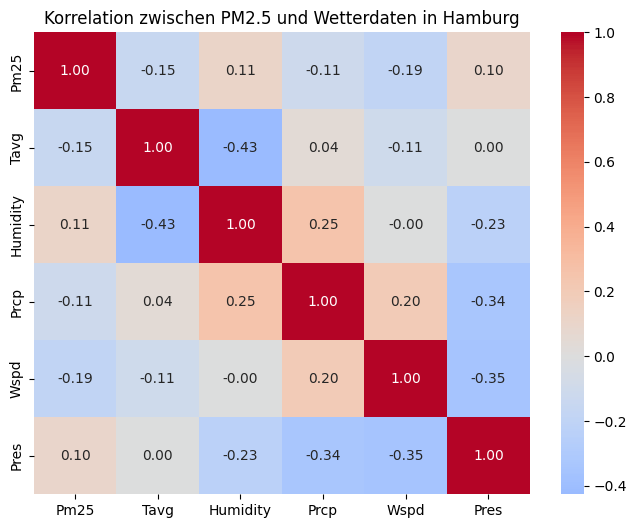

In [10]:
# Berechnung der Korrelationsmatrix
correlation_matrix = df_hamburg_pm25[['Pm25', 'Tavg', 'Humidity', 'Prcp', 'Wspd', 'Pres']].corr()

# Visualisierung der Korrelationsmatrix mit 'center=0'

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Korrelation zwischen PM2.5 und Wetterdaten in Hamburg')

Eine starke Korrelation zwischen dem Feinstaubwert und einer Wettervariablen ist nicht unmittelbar offensichtlich. Am stärksten ist mit -0,19 die Korrelation mit der Windgeschwindigkeit. Das bedeutet, dass in Zeiten mit wenig Wind die PM2.5-Werte tendenziell höher sind. Dies ist zu erwarten, da Wind dazu beiträgt, Luftschadstoffe zu vertreiben, während ruhiges Wetter (wenig Wind) zu einer Ansammlung von Schadstoffen führen kann.

# 2. Baseline-Modell: Lineare Regression

Bevor wir ein Modell für lineare Regression verwenden können, müssen wir die NaN-Werte behandeln. Da wir Datumsangaben haben, könnten wir die Werte des Vortrags, bzw. der vorhergehenden Messung imputieren. Da der Datensatz aber mehrere längere Lücken aufweist, entscheiden wir uns für eine Imputation über den Median.

In [11]:
# Inputiere NaN-Werte mit dem Median der jeweiligen Spalte
df_hamburg_pm25.fillna(df_hamburg_pm25.median(), inplace=True)

# Überprüfung, ob NaN-Werte noch vorhanden sind
print(df_hamburg_pm25.isna().sum())

Year        0
Month       0
Day         0
Pm25        0
Tavg        0
Humidity    0
Prcp        0
Wspd        0
Pres        0
dtype: int64


/var/folders/9l/_gqvrbsd14zb0w_nlgtngd_w0000gn/T/ipykernel_45298/4149308259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hamburg_pm25.fillna(df_hamburg_pm25.median(), inplace=True)


#### Lineare Regression mit Scikit-Learn und Statsmodels

Es soll ein lineares Regressionsmodell erstellt werden, um den Zusammenhang zwischen der Feinstaubbelastung (PM2.5) und verschiedenen Wetterfaktoren zu untersuchen.

Dabei werden zwei Bibliotheken kombiniert:

- **Scikit-Learn**: zum Trainieren des Modells und zur Berechnung des Bestimmtheitsmaßes $r^2$
- **Statsmodels**: zur detaillierten Analyse des Modells (Koeffizienten, Standardfehler, p-Werte, Konfidenzintervalle, usw.)

Die verwendeten unabhängigen Variablen (Features) sind:

- Durchschnittstemperatur (`Tavg`)
- Luftfeuchtigkeit (`Humidity`)
- Niederschlag (`Prcp`)
- Windgeschwindigkeit (`Wspd`)
- Luftdruck (`Pres`)

Die abhängige Variable ist die Feinstaubkonzentration (`Pm25`).


In [12]:
# Feature-Auswahl & Zielvariable definieren
features = ['Tavg', 'Humidity', 'Prcp', 'Wspd', 'Pres']
X = df_hamburg_pm25[features]
y = df_hamburg_pm25['Pm25']

In [13]:
# Modelltraining
lr_model = LinearRegression()
lr_model.fit(X, y)

LinearRegression()

In [14]:
# Statsmodels: Regressionsanalyse mit Zusammenfassung
X_sm = sm.add_constant(X)  # Intercept hinzufügen
ols_model = sm.OLS(y, X_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Pm25   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     43.76
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           1.36e-43
Time:                        11:11:54   Log-Likelihood:                -12634.
No. Observations:                2834   AIC:                         2.528e+04
Df Residuals:                    2828   BIC:                         2.532e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9530     45.808      0.152      0.8

### 📊 Interpretation der Regressionsanalyse

Die lineare Regressionsanalyse wurde durchgeführt, um den Einfluss verschiedener Wetterfaktoren auf die PM2.5-Konzentration in Hamburg zu untersuchen. Die Ergebnisse zeigen Folgendes:

#### 🔹 Modellgüte

- **r^2 = 0,072**: Nur etwa **7,2 %** der Varianz der PM2.5-Werte kann durch die gewählten Wettervariablen erklärt werden. Das Modell hat also eine geringe Vorhersagekraft.
- **Adj. r^2 = 0,070**: Auch die bereinigte Variante (angepasst an die Anzahl der Prädiktoren) bestätigt die geringe Erklärungskraft.
- **F-Statistik = 43.76**, **p < 0.001**: Das Modell als Ganzes ist dennoch **statistisch signifikant**, d. h. mindestens einer der Prädiktoren trägt systematisch zur Erklärung von PM2.5 bei.

#### 🔹 Koeffizienten und Signifikanz

| Variable   | Einflussrichtung | p-Wert  | Interpretation |
|------------|------------------|---------|----------------|
| **Tavg**   | negativ          | 0.000   | Höhere Temperaturen gehen mit niedrigeren PM2.5-Werten einher. |
| **Humidity** | positiv        | 0.000   | Höhere Luftfeuchtigkeit ist mit leicht erhöhten PM2.5-Werten assoziiert. |
| **Prcp**   | negativ          | 0.000   | Niederschlag reduziert die PM2.5-Konzentration – vermutlich durch Auswaschungseffekte. |
| **Wspd**   | negativ          | 0.000   | Höhere Windgeschwindigkeit führt zu einer Verdünnung von Feinstaub. |
| **Pres**   | kein signifikanter Effekt | 0.378 | Luftdruck scheint keinen nennenswerten Einfluss auf PM2.5 zu haben. |

Alle Wettervariablen außer dem Luftdruck zeigen einen **statistisch signifikanten Einfluss** auf die Feinstaubbelastung (p < 0.05).

#### 🧭 Fazit

Auch wenn das Modell nur einen kleinen Teil der Variation erklären kann, lassen sich einige **systematische Zusammenhänge** zwischen Wetterbedingungen und PM2.5-Konzentration erkennen. Diese Nehmen wir als Ausgangspunkt für das Feature Engineering.


# 3. Feature Engineering

Im Folgenden werden die im Modell verwendeten Features nacheinander bearbeitet mit dem Ziel, die Modellgüte zu verbessern. Da das Modell insgesamt sehr schwach ist, wird keine überragende Verbesserung durch das Feature Engineering erwartet. Es soll aber gezeigt werden, welche Methoden prinzipiell zur Verfügung stehen.


## 3.1. Feature Reduction

Basierend auf der vorherigen Regressionsanalyse wurde der Luftdruck (`Pres`) als **nicht signifikant** identifiziert (p = 0.378). In diesem Schritt wird `Pres` aus dem Feature-Set entfernt, um zu überprüfen, ob sich die Modellgüte dadurch verbessert oder konstant bleibt.

In [15]:
# Neues Feature-Set ohne 'Pres'
X_reduced = df_hamburg_pm25[['Tavg', 'Humidity', 'Prcp', 'Wspd']]
y = df_hamburg_pm25['Pm25']

# Mit Statsmodels analysieren
X_reduced = sm.add_constant(X_reduced)
model_reduced = sm.OLS(y, X_reduced).fit()
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:                   Pm25   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     54.50
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           2.53e-44
Time:                        11:11:54   Log-Likelihood:                -12635.
No. Observations:                2834   AIC:                         2.528e+04
Df Residuals:                    2829   BIC:                         2.531e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.2142      3.513     13.439      0.0

#### Ergebnis:

- Das neue Modell enthält nur noch vier Wettervariablen: `Tavg`, `Humidity`, `Prcp` und `Wspd`.
- Das Bestimmtheitsmaß $R^2$ bleibt mit **0.072** unverändert.
- Auch das bereinigte $R^2$ sowie die AIC- und BIC-Werte bleiben nahezu gleich.
- Damit zeigt sich, dass der Luftdruck keinen relevanten Beitrag zur Modellgüte leistet und ohne Informationsverlust entfernt werden kann.

👉 Dies ist ein typisches Beispiel für **Feature-Selektion als Teil des Feature Engineerings**, bei dem überflüssige oder irrelevante Variablen identifiziert und entfernt werden, um Modelle robuster und interpretierbarer zu machen.

## 3.2. Feature Transformation

Wenn die Messwerte, die in die lineare Regression einfließen, direkt übernommen werden, wird davon ausgegangen, dass die Zusammenhänge zwischne den einzelnen Features und dem Target linear sind. Dies ist aber nicht immer der Fall. Um zu überprüfen, von welcher Art die Zusammenhänge zwischen dem Feinstaubwert und anderen Variablen tatsächlich sind, ist eine Visualisierung mit LOWESS-Regression hilfreich:


/Users/mareikekeller/air_quality/.venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


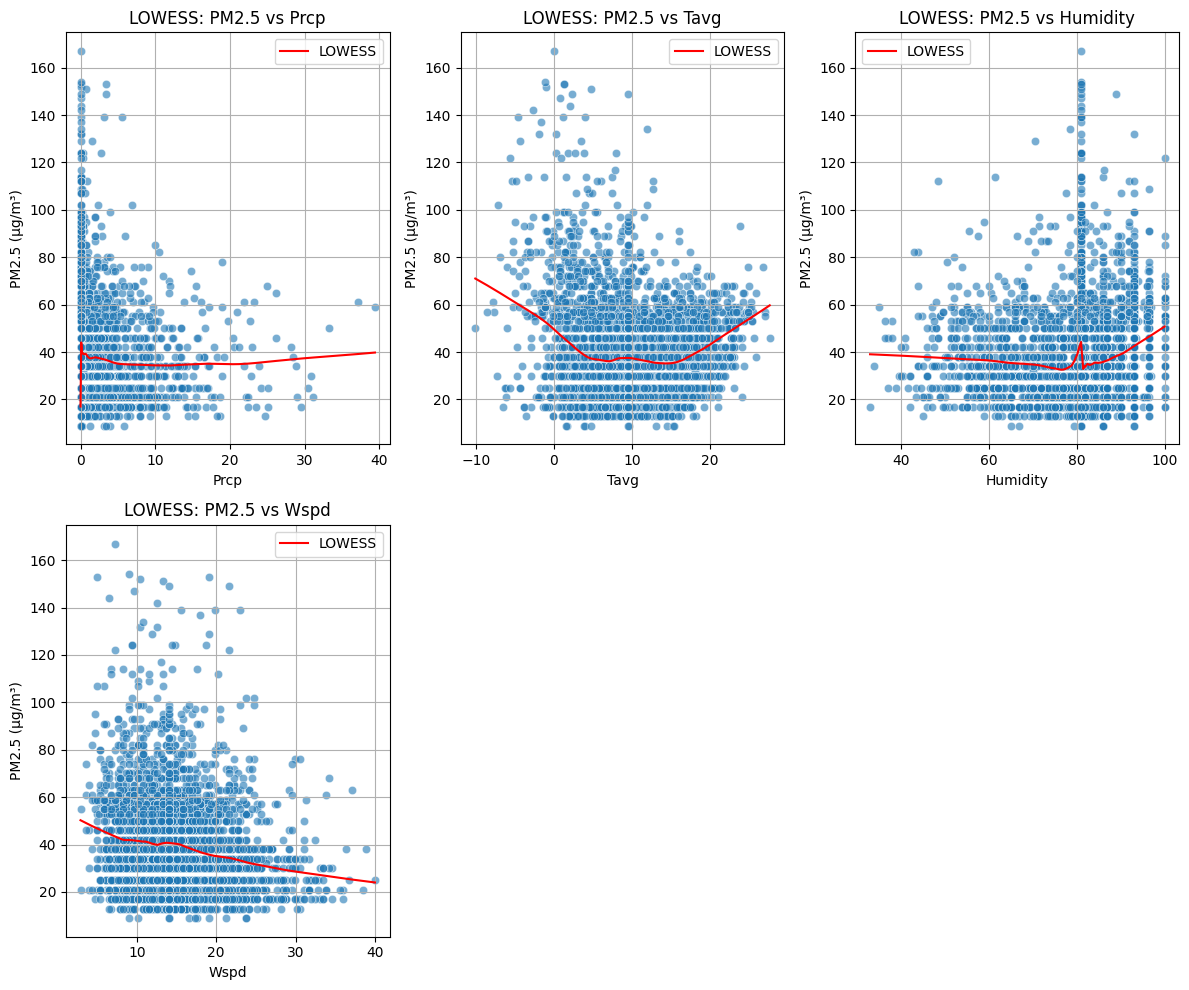

In [16]:
# Liste der Variablen für die Analyse
variables = ['Prcp', 'Tavg', 'Humidity', 'Wspd']

# Erstelle Scatterplots mit LOWESS-Glättung
plt.figure(figsize=(12, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)  # 2 Zeilen, 3 Spalten
    sns.scatterplot(x=df_hamburg_pm25[var], y=df_hamburg_pm25['Pm25'], alpha=0.6)
    
    # LOWESS-Glättung anwenden
    lowess_result = lowess(df_hamburg_pm25['Pm25'], df_hamburg_pm25[var], frac=0.3)
    plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='red', label='LOWESS')
    
    plt.title(f'LOWESS: PM2.5 vs {var}')
    plt.xlabel(var)
    plt.ylabel('PM2.5 (µg/m³)')
    plt.grid(True)
    plt.legend()

plt.tight_layout();


Der Plot, dass der Zusammenhang zwischen Feinstaub und den Wettervariablen Niederschlag, Durchschnittstemperatur und Luftfeuchtigkeit nicht linear sind. Der Zusammenhang mit der Windgeschwindigkeit ist linear: Je höher die Windgeschwindigkeit, desto niedriger die Feinstaubbelastung.

Um die Features, die keine direkte lienare Abh#ngigkeit zeigen, für eine lineare Regression besser nutzbar zu machen, werden im Folgenden zwei mathematische Transformationsmöglichkeiten vorgestellt:

- **Logarithmierung** der Niederschlagswerte
- Zusätzlicher **quadratischer Term** für die Durchschnittstemperatur

Feature Transformation ist **eine Möglichkeit** den beobachteten nicht-linearen Zusammenhängen zu begegnen. Eine andere, unter Umständen effektivere Möglichkeit wäre es, zur Vorhersage des Feinstaubwerts ein Modell zu verwenden, das nicht auf linearen Beziehungen basiert. Hier soll aber erst einmal gezeigt werden, was im Rahmen der linearen Regression, die ein einfaches und vor allen **direkt interpretierbares Modell** darstellt, an Verbesserungen der Modellgüte erreicht werden kann.

#### Logarithmierung der Niederschlagswerte

Niederschlagswerte (`Prcp`) sind in stark **rechtsschief verteilt**: An vielen Tagen regnet es gar nicht (senkrechte Linie beim Wert 0), an einigen wenigen Tagen dagegen sehr stark (hohe Ausreißerwerte). Diese ungleichmäßige Verteilung für zu einer starken Verzerrung lineare Modelle.

Um dem entgegenzuwirken, wurde eine **logarithmische Transformation** durchgeführt. Da der Logarithmus von 0 nicht definiert ist, wird mit log(Prcp + 1) gerechnet:

$$\text{Log\_Prcp} = \log(\text{Prcp} + 1)$$

Effekte der Logarithmierung:
- Große Niederschlagswerte werden **komprimiert** → Ausreißer verlieren an Einfluss  
- Kleine Werte (v. a. der Unterschied zwischen 0 und 1 mm) werden **stärker betont**  
- Das Modell kann feiner auf **leichte Regenmengen** reagieren, die sich auf die Luftqualität auswirken können  

In [17]:

# Neue Spalte mit logarithmierter Niederschlagsmenge
df_hamburg_pm25['Log_Prcp'] = np.log(df_hamburg_pm25['Prcp'] + 1)

# Neues Feature-Set (Log_Prcp statt Prcp)
X_log = df_hamburg_pm25[['Tavg', 'Humidity', 'Log_Prcp', 'Wspd']]
y = df_hamburg_pm25['Pm25']

# Modell fitten
X_log = sm.add_constant(X_log)
model_log = sm.OLS(y, X_log).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                   Pm25   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     59.63
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           2.08e-48
Time:                        11:11:54   Log-Likelihood:                -12625.
No. Observations:                2834   AIC:                         2.526e+04
Df Residuals:                    2829   BIC:                         2.529e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.9169      3.581     12.264      0.0

/var/folders/9l/_gqvrbsd14zb0w_nlgtngd_w0000gn/T/ipykernel_45298/3891626089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hamburg_pm25['Log_Prcp'] = np.log(df_hamburg_pm25['Prcp'] + 1)


#### Ergebnis:

- Die lineare Variable `Prcp` wurde durch `Log_Prcp` ersetzt.
- Das neue Modell zeigt ein leicht verbessertes Bestimmtheitsmaß:
  - $R^2$: von **0.072** → **0.078**
  - Adj. $R^2$: von **0.070** → **0.076**
- Auch AIC und BIC sind etwas gesunken → das neue Modell ist **effizienter**.
- Der Koeffizient von `Log_Prcp` ist mit **-3.13** stark negativ und hoch signifikant (p < 0.001), was auf eine deutliche Reduktion von PM2.5 bei zunehmendem Regen hinweist (nach log-Skalierung).

➡️ Diese Transformation ist ein klassisches Beispiel dafür, wie **Feature Engineering** helfen kann, nichtlineare Zusammenhänge **besser erfassbar zu machen** und das Modell zu verbessern.


#### Quadratischer Term für Temperaturwerte

Um zu prüfen, ob der Zusammenhang zwischen Temperatur (`Tavg`) und Feinstaubkonzentration (`Pm25`) nichtlinear ist, wurde in diesem Schritt ein **quadratischer Term** (`Tavg_squared`) ergänzt:

- Sowohl der lineare als auch der quadratische Term wurden in das Modell aufgenommen.
- Die neue Modellform erlaubt es, auch U- oder umgekehrt U-förmige Zusammenhänge abzubilden.

🔍 Hinweis: Die Beziehung zwischen Temperatur (`Tavg`) und PM2.5 ist grob U-förmig, was durch die quadratische Transformation abgebildet wird. Im LOWESS-Plot zeigt sich, wenn man es sehr genau nimmt, jedoch eine schwach ausgeprägte **W-Form**, mit zwei lokalen Tiefpunkten (ca. 5 °C und 15 °C) und einem Hochpunkt dazwischen. Dieser Verlauf wurde **nicht mathematisch modelliert**, da er ein prinzipiell linear angesetzes Modell zu komplex machen würde und möglicherweise auch einfach auf **saisonale Überschneidungen** oder **Messartefakte** zurückzuführen ist.

In [18]:
# Quadratischer Term für Temperatur
df_hamburg_pm25['Tavg_squared'] = df_hamburg_pm25['Tavg'] ** 2

# Neues Feature-Set inkl. Tavg² und Log_Prcp
X_quad = df_hamburg_pm25[['Tavg', 'Tavg_squared', 'Humidity', 'Log_Prcp', 'Wspd']]
y = df_hamburg_pm25['Pm25']

# Modell mit quadratischer Temperaturkomponente
X_quad = sm.add_constant(X_quad)
model_quad = sm.OLS(y, X_quad).fit()
print(model_quad.summary())

                            OLS Regression Results                            
Dep. Variable:                   Pm25   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     78.41
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           3.24e-77
Time:                        11:11:54   Log-Likelihood:                -12556.
No. Observations:                2834   AIC:                         2.512e+04
Df Residuals:                    2828   BIC:                         2.516e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           38.9646      3.520     11.070   

/var/folders/9l/_gqvrbsd14zb0w_nlgtngd_w0000gn/T/ipykernel_45298/4099163750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hamburg_pm25['Tavg_squared'] = df_hamburg_pm25['Tavg'] ** 2



#### Ergebnis:

- Das Modell zeigt eine deutliche Verbesserung:
  - $R^2$: von **0.078** → **0.122**
  - Adj. $R^2$: von **0.076** → **0.120**
  - AIC/BIC ebenfalls gesunken → effizienteres Modell
- Beide Temperatur-Terme (`Tavg` und `Tavg_squared`) sind **hoch signifikant** (p < 0.001)
- Der negative Koeffizient von `Tavg` und der positive von `Tavg_squared` deuten auf einen **U-förmigen Zusammenhang** hin:  
  Sehr niedrige und sehr hohe Temperaturen gehen mit **erhöhter Feinstaubbelastung** einher, während mittlere Temperaturen tendenziell niedrigere Werte zeigen.

➡️ Diese Erweiterung zeigt, wie sich mit gezielten Transformationen **wichtige Muster sichtbar machen** lassen, die in einem rein linearen Modell verborgen geblieben wären.


## 3.3. Feature Split

Ein Blick auf den LOWESS-Plot zwischen Luftfeuchtigkeit (`Humidity`) und PM2.5-Werten zeigt einen deutlich **nichtlinearen Zusammenhang**:

- Bis zu einer Luftfeuchtigkeit von etwa **80 %** nimmt die PM2.5-Konzentration leicht ab  
- Ab **80 %** kehrt sich der Effekt um, und die Werte steigen deutlich an

Um diesen Knick im Zusammenhang mathematisch abbilden zu können, wurde `Humidity` in zwei neue Features gesplittet:

- `Humidity_low`: Luftfeuchtigkeit bis 80 %  
- `Humidity_high`: Anteil über 80 % (abgeschnittene Differenz)

Ziel war es, dem Modell zu ermöglichen, **zwei unterschiedliche Effekte** für niedrige und sehr hohe Luftfeuchtigkeit zu lernen.


In [21]:
# Neue Features erstellen
df_hamburg_pm25.loc[:, 'Humidity_low'] = df_hamburg_pm25.loc[:, 'Humidity'].clip(upper=80)
df_hamburg_pm25.loc[:, 'Humidity_high'] = (df_hamburg_pm25['Humidity'] - 80).clip(lower=0)


In [ ]:
# Neues Feature-Set inkl. Humidity_low und Humidity_high
X_split = df_hamburg_pm25[['Tavg', 'Tavg_squared', 'Humidity_low', 'Humidity_high', 'Log_Prcp', 'Wspd']]
y = df_hamburg_pm25['Pm25']

# Modell mit gesplittetem Feature
X_split = sm.add_constant(X_split)
model_split = sm.OLS(y, X_split).fit()
print(model_split.summary())


                            OLS Regression Results                            
Dep. Variable:                   Pm25   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     65.69
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           1.13e-76
Time:                        11:15:18   Log-Likelihood:                -12555.
No. Observations:                2834   AIC:                         2.512e+04
Df Residuals:                    2827   BIC:                         2.517e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            35.8710      4.147      8.651

Die Modellgüte hat sich durch den Feature-Split **nicht weiter verbessert**, aber der Schritt zeigt beispielhaft, wie **nichtlineare Muster** durch Zerlegung von Variablen in einem linearen Modell berücksichtigt werden können.

## 3.4. Interaktionsterme

Neben der Vereinfachung des Modells durch Feature Reduction und der Anpassung durch Feature Transformation besteht im Rahmen des Feature Engineerings auch die Möglichkeit, die Möglichkiet, dass zwei Features in Interaktion einen Einfluss auf das Target haben, zu modellieren. Dafür werden Features addiert oder multipliziert, und der entstehende **Interkationsterm** wird dem Modell als zusätzliches Feature übergeben.

In einem explorativen Schritt wird nun geprüft, ob eine **Interaktion zwischen Temperatur und Luftfeuchtigkeit** (`Tavg * Humidity`) einen zusätzlichen Einfluss auf die Feinstaubbelastung haben könnte, denn:

- Temperatur und Luftfeuchtigkeit beeinflussen gemeinsam viele chemische Reaktionen in der Atmosphäre
- Bei hoher Luftfeuchtigkeit kann z. B. Feinstaub stärker „gebunden“ oder verteilt werden – das hängt aber vom Temperaturverlauf ab


In [24]:
# Interaktionsterm: Temperatur * Luftfeuchtigkeit
df_hamburg_pm25['Tavg_Humidity'] = df_hamburg_pm25['Tavg'] * df_hamburg_pm25['Humidity']

# Neues Feature-Set
X_inter = df_hamburg_pm25[['Tavg', 'Tavg_squared', 'Humidity_low', 'Humidity_high', 'Log_Prcp', 'Wspd', 'Tavg_Humidity']]
y = df_hamburg_pm25['Pm25']

# Modell mit Interaktionsterm
X_inter = sm.add_constant(X_inter)
model_inter = sm.OLS(y, X_inter).fit()
print(model_inter.summary())

                            OLS Regression Results                            
Dep. Variable:                   Pm25   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     56.31
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           9.10e-76
Time:                        11:16:05   Log-Likelihood:                -12555.
No. Observations:                2834   AIC:                         2.513e+04
Df Residuals:                    2826   BIC:                         2.517e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            33.6814      8.069      4.174

/var/folders/9l/_gqvrbsd14zb0w_nlgtngd_w0000gn/T/ipykernel_45298/147358452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hamburg_pm25['Tavg_Humidity'] = df_hamburg_pm25['Tavg'] * df_hamburg_pm25['Humidity']


#### Ergebnis:

- Der Interaktionsterm `Tavg_Humidity` wurde dem Modell hinzugefügt.
- Der zugehörige **p-Wert liegt bei 0.76**, d. h. die Variable ist **nicht signifikant**.
- Auch die Modellgüte bleibt unverändert:
  - $R^2$ = 0.122 (wie im Modell ohne Interaktion)
  - AIC und BIC sind minimal **gestiegen**
- Fazit: Diese Interaktion liefert **keinen Mehrwert** für das Modell und kann wieder entfernt werden.

Dieser Schritt zeigt also, wie einen Kombination von Features prinzipiell funktioniert, aber auch, dass nicht jede theoretisch plausible Kombination von Features ein Modell auch wirklich verbessert.


## 3.5. Zeitvariablen

Neben numerischen Transformationen und Interaktionstermen kann auch die **zeitliche Einordnung von Daten** ein wichtiger Bestandteil des Feature Engineerings sein, und zwar dann, wenn der Zusammenhang zwischen Features und Target saisonale Muster aufweist. In diesem Schritt wird die ursprüngliche Monatsinformation (`Month`) genutzt, um daraus eine neue kategoriale Variable `Season` (Jahreszeit) zu erzeugen.

Hintergrund: Die Feinstaubbelastung unterliegt typischerweise **saisonalen Schwankungen**, etwa durch Heizemissionen im Winter, Inversionswetterlagen oder erhöhte Luftumwälzung im Sommer. Durch die Einbindung dieser Information als Modellfeature lassen sich solche Effekte gezielt abbilden.

Dazu wird `Season` in **Dummy-Variablen** umgewandelt, die in das Regressionsmodell einfließen. Auf diese Weise kann untersucht werden, ob sich die PM2.5-Konzentration **systematisch zwischen den Jahreszeiten unterscheidet** – und ob diese Zeitinformation zur Verbesserung der Modellgüte beiträgt.

Zur Einbindung der Zeitvariable `Season` in das Regressionsmodell wird die kategoriale Variable mithilfe von **One-Hot-Encoding** in **Dummy-Variablen** umgewandelt. Dabei gilt:

Jede Ausprägung einer kategorialen Variable wird zu einer eigenen Spalte, die nur den Wert `1` trägt, wenn die Zeile zu dieser Kategorie gehört – sonst `0`.

Beispiel für 4 Jahreszeiten:

| Season   | Winter | Frühling | Sommer | Herbst |
|----------|--------|----------|--------|--------|
| Sommer   | 0      | 0        | 1      | 0      |
| Herbst   | 0      | 0        | 0      | 1      |
| Winter   | 1      | 0        | 0      | 0      |
| Frühling | 0      | 1        | 0      | 0      |

Allerdings sollte in Regressionsmodellen **eine Kategorie ausgelassen** werden (hier: **Frühling**). Sie dient als **Referenzkategorie**. Dadurch vermeidet man **Multikollinearität**, also mathematische Redundanz im Modell. Das bedeutet:

- Die Effekte aller anderen Kategorien (Herbst, Sommer, Winter) werden im **Vergleich zum Frühling** berechnet.
- Beispiel: Ein Koeffizient von `-8.94` für Herbst bedeutet, dass die PM2.5-Konzentration im Herbst im Durchschnitt **8.94 µg/m³ niedriger ist als im Frühling**, wenn alle anderen Einflussfaktoren konstant gehalten werden.

In [29]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Frühling'
    elif month in [6, 7, 8]:
        return 'Sommer'
    else:
        return 'Herbst'

df_hamburg_pm25.loc[:, 'Season'] = df_hamburg_pm25['Month'].apply(get_season)

df_hamburg_pm25.head()

,Year,Month,Day,Pm25,Tavg,Humidity,Prcp,Wspd,Pres,Log_Prcp,Tavg_squared,Humidity_low,Humidity_high,Tavg_Humidity,Season
490691,2014,12,29,34.00,9.50,81.00,0.10,14.00,"1,015.40",0.10,90.25,80.00,1.00,769.50,Winter
490692,2014,12,30,34.00,9.50,81.00,0.10,14.00,"1,015.40",0.10,90.25,80.00,1.00,769.50,Winter
490693,2014,12,31,38.00,9.50,81.00,0.10,14.00,"1,015.40",0.10,90.25,80.00,1.00,769.50,Winter
490694,2015,1,1,99.00,3.60,81.00,3.90,23.00,"1,028.20",1.59,12.96,80.00,1.00,291.60,Winter
490695,2015,1,2,61.00,6.30,81.00,4.00,33.80,"1,016.60",1.61,39.69,80.00,1.00,510.30,Winter


In [30]:
# Saison in Dummy-Variablen umwandeln (Frühling als Referenzkategorie)
season_dummies = pd.get_dummies(df_hamburg_pm25['Season'], drop_first=True, dtype=int)

In [41]:
# Basis-Features
features_base = df_hamburg_pm25[['Tavg', 'Tavg_squared', 'Humidity', 'Log_Prcp', 'Wspd']]

# Kombinieren mit Saison-Dummies
X_season = pd.concat([features_base, season_dummies], axis=1)
y = df_hamburg_pm25['Pm25']

# Modell aufbauen und ausgeben
X_season = sm.add_constant(X_season)
model_season = sm.OLS(y, X_season).fit()
print(model_season.summary())


                            OLS Regression Results                            
Dep. Variable:                   Pm25   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     75.41
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          4.75e-113
Time:                        11:31:29   Log-Likelihood:                -12465.
No. Observations:                2834   AIC:                         2.495e+04
Df Residuals:                    2825   BIC:                         2.500e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           32.4652      3.506      9.260   

#### Ergebnis

Durch die Einbindung der Jahreszeiten als Dummy-Variablen (Herbst, Sommer, Winter; Referenzkategorie: Frühling) konnte die Modellgüte deutlich verbessert werden:

- $R^2$: von **0.122** auf **0.176**
- Adj. $R^2$: von **0.120** auf **0.174**

Die Zeitvariable trägt somit eindeutig zur Erklärung der PM2.5-Werte bei.

**Interpretation der saisonalen Koeffizienten:**

- `Herbst`: Im Vergleich zum Frühling ist die PM2.5-Belastung im Herbst im Durchschnitt um **8.9 µg/m³** niedriger  
- `Sommer`: Noch deutlicher fällt der Sommer aus – hier ist die Belastung **16.7 µg/m³** niedriger als im Frühling  
- `Winter`: Im Gegensatz dazu ist im Winter ein leichter **Anstieg** um **3.1 µg/m³** gegenüber dem Frühling zu beobachten

Diese saisonalen Unterschiede lassen sich z. B. durch **veränderte meteorologische Bedingungen**, **Heizverhalten** oder **Verkehrsdichte** erklären. Besonders der hohe Unterschied zum Sommer deutet auf eine insgesamt bessere Luftqualität in den warmen Monaten hin.

Die Einbindung der saisonalen Struktur in Form von Dummy-Variablen verbessert nicht nur die Modellgüte, sondern erhöht auch die Interpretierbarkeit – z. B. für politische oder zeitbezogene Maßnahmen zur Luftreinhaltung.


# 4. Fazit: Wirkung von Feature Engineering auf das Regressionsmodell

In diesem Notebook wurde schrittweise untersucht, wie sich gezielte Maßnahmen des **Feature Engineerings** auf die Vorhersagekraft eines linearen Regressionsmodells zur Feinstaubbelastung (PM2.5) auswirken. Ausgangspunkt war ein einfaches Modell mit fünf Wettervariablen, das lediglich **7,2 % der Varianz** erklären konnte.

Durch systematische Erweiterung und Optimierung der Features wurde das Modell deutlich verbessert:

| Maßnahme                          | Verbesserung                                   |
|----------------------------------|------------------------------------------------|
| Entfernen nicht signifikanter Variablen (`Pres`) | Kein Informationsverlust, schlankeres Modell |
| Log-Transformation (`log(Prcp + 1)`)            | Bessere Modellanpassung durch Stabilisierung der Skala |
| Quadratischer Term (`Tavg²`)     | Erfassung nichtlinearer Effekte, spürbare Steigerung von $R^2$ |
| Zeitvariable (`Season` als Dummy) | Deutlicher Leistungszuwachs, klare saisonale Muster |
| $R^2$ gesamt                 | von **0.072** → **0.177** (+145 %)             |

Zusätzlich wurde gezeigt, dass **nicht jede Feature-Kombination sinnvoll ist**: Ein getesteter Interaktionsterm (`Tavg * Humidity`) hatte keinen signifikanten Einfluss und wurde wieder entfernt.

➡️ Insgesamt zeigt dieses Notebook, wie **datengetriebenes Feature Engineering** schrittweise zu einem leistungsfähigeren und interpretierbareren Modell führen kann – eine Kernkompetenz in der datenanalytischen Praxis.


# 5. Bonus: Weitere Luftschadstoffe als erklärende Variablen

Im bisherigen Verlauf des Notebooks lag der Fokus auf der Frage, wie sich Wetterbedingungen und saisonale Effekte auf die Feinstaubbelastung (PM2.5) auswirken. Ein weiterer sinnvoller Analyseansatz besteht darin, zu prüfen, ob auch **andere Luftschadstoffe** (z. B. NO₂, SO₂, CO, O₃) dabei helfen können, PM2.5-Konzentrationen besser vorherzusagen.

Hintergrund: Viele Luftschadstoffe stehen miteinander in Zusammenhang – sie entstehen gemeinsam (z. B. durch Verkehr oder Industrie) oder beeinflussen sich chemisch gegenseitig. Durch die Einbindung dieser Variablen lässt sich testen, ob ein **Mehrkomponentenmodell** die Modellgüte weiter verbessern kann.

In diesem Abschnitt wird daher das bestehende Regressionsmodell um weitere Schadstoffvariablen erweitert ()`No2`, `O3`, `So2`). Diese Schadstoffe stehen in der Realität oft in engem Zusammenhang mit PM2.5, da sie aus ähnlichen Quellen stammen oder in gemeinsamen atmosphärischen Prozessen auftreten. Ziel ist es, den Erklärungswert des Modells zu steigern und gleichzeitig mögliche Wechselwirkungen zwischen den Schadstoffen sichtbar zu machen.


#### 🚫 Hinweis zur Datenqualität: CO-Konzentration

Bei der explorativen Untersuchung der Beziehung zwischen PM2.5 und Kohlenmonoxid (CO) fiel auf, dass in den vorliegenden Daten **ausschließlich der konstante Wert 0.10** für CO eingetragen ist. Dies ist physikalisch unrealistisch und spricht dafür, dass es sich um:

- eine Füllkonstante
- oder eine fehlerhafte Messreihe

handelt. Aufgrund der fehlenden Varianz ist CO **für die Regressionsanalyse nicht sinnvoll nutzbar**. Die ursprünglich im Modell enthaltene hohe Koeffizienz von CO (über 400) ist damit wahrscheinlich **ein Artefakt** der schlechten Datenqualität.

➡️ Die Variable CO wird im erweiterten Modell ausgeschlossen.

In [42]:
# Relevante Spalten aus df_hamburg holen
pollutants = df_hamburg[['No2', 'O3', 'So2']]

# Schadstoffe in df_hamburg_pm25 hinzufügen
df_hamburg_pm25_extended = df_hamburg_pm25.copy()
df_hamburg_pm25_extended[['No2', 'O3', 'So2']] = pollutants

In [43]:
df_hamburg_pm25_extended.head()

,Year,Month,Day,Pm25,Tavg,Humidity,Prcp,Wspd,Pres,Log_Prcp,Tavg_squared,Humidity_low,Humidity_high,Tavg_Humidity,Season,No2,O3,So2
490691,2014,12,29,34.00,9.50,81.00,0.10,14.00,"1,015.40",0.10,90.25,80.00,1.00,769.50,Winter,11.00,16.30,1.60
490692,2014,12,30,34.00,9.50,81.00,0.10,14.00,"1,015.40",0.10,90.25,80.00,1.00,769.50,Winter,15.10,15.10,3.10
490693,2014,12,31,38.00,9.50,81.00,0.10,14.00,"1,015.40",0.10,90.25,80.00,1.00,769.50,Winter,11.90,12.60,3.10
490694,2015,1,1,99.00,3.60,81.00,3.90,23.00,"1,028.20",1.59,12.96,80.00,1.00,291.60,Winter,9.20,13.90,2.60
490695,2015,1,2,61.00,6.30,81.00,4.00,33.80,"1,016.60",1.61,39.69,80.00,1.00,510.30,Winter,6.00,22.80,1.60


In [44]:
df_hamburg_pm25_extended.isna().sum()

Year              0
Month             0
Day               0
Pm25              0
Tavg              0
Humidity          0
Prcp              0
Wspd              0
Pres              0
Log_Prcp          0
Tavg_squared      0
Humidity_low      0
Humidity_high     0
Tavg_Humidity     0
Season            0
No2               2
O3                2
So2              50
dtype: int64

In [45]:
season_dummies = pd.get_dummies(df_hamburg_pm25_extended['Season'], drop_first=True, dtype=int)


In [46]:
# Kombiniertes DataFrame mit allen Features und Ziel
df_model = pd.concat([
    df_hamburg_pm25_extended[['Tavg', 'Tavg_squared', 'Humidity', 'Log_Prcp', 'Wspd', 'No2', 'O3', 'So2', 'Pm25']],
    season_dummies
], axis=1)

# Nur vollständige Zeilen behalten
df_model = df_model.dropna()


In [47]:
X_final = df_model.drop(columns='Pm25')
y_final = df_model['Pm25']

# Konstanten-Term hinzufügen
X_final = sm.add_constant(X_final)

# Modell trainieren
model_final = sm.OLS(y_final, X_final).fit()
print(model_final.summary())



                            OLS Regression Results                            
Dep. Variable:                   Pm25   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     99.11
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          2.09e-190
Time:                        11:32:20   Log-Likelihood:                -12059.
No. Observations:                2784   AIC:                         2.414e+04
Df Residuals:                    2772   BIC:                         2.421e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           42.3828      4.803      8.824   

#### Ergebnis:

- Das erweiterte Modell zeigt eine deutliche Leistungssteigerung:
  - $R^2$: von **0.176** → **0.282**
  - Adj. $R^2$: von **0.174** → **0.280**
  - AIC und BIC sinken deutlich
- Alle hinzugefügten Schadstoffe sind **statistisch signifikant**, mit plausiblen Wirkungsrichtungen:
  - **NO₂, SO₂**: positiv korreliert mit PM2.5
  - **O₃**: negativer Zusammenhang
- Die Windgeschwindigkeit (`Wspd`) verliert im erweiterten Modell an Signifikanz – möglicherweise, weil ihre Wirkung durch die Schadstoffkonzentrationen überlagert wird

➡️ Die Einbindung weiterer Luftschadstoffe als erklärende Variablen erhöht die **Modellgüte substanziell** und bietet zusätzliche Einsichten in komplexe Zusammenhänge zwischen Umweltfaktoren und Feinstaubbelastung.


Da die Zusammenhänge zwischen Feinstaubbelastung und den anderen Schadstoffen nicht notwenigerweise linear sind, soll diese Annahme wieder mit LOWESS-Regression überprüft werden.

/Users/mareikekeller/air_quality/.venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


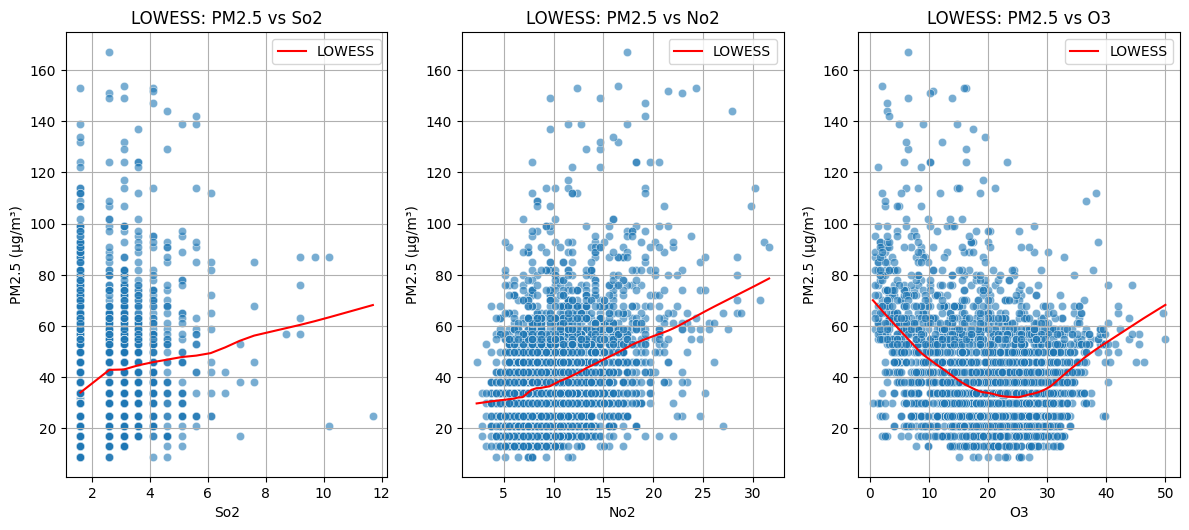

In [48]:
# Liste der Variablen für die Analyse
variables = ['So2', 'No2', 'O3']

# Erstelle Scatterplots mit LOWESS-Glättung
plt.figure(figsize=(12, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)  # 2 Zeilen, 3 Spalten
    sns.scatterplot(x=df_hamburg_pm25_extended[var], y=df_hamburg_pm25_extended['Pm25'], alpha=0.6)
    
    # LOWESS-Glättung anwenden
    lowess_result = lowess(df_hamburg_pm25_extended['Pm25'], df_hamburg_pm25_extended[var], frac=0.3)
    plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='red', label='LOWESS')
    
    plt.title(f'LOWESS: PM2.5 vs {var}')
    plt.xlabel(var)
    plt.ylabel('PM2.5 (µg/m³)')
    plt.grid(True)
    plt.legend()

# plt.ylim(0, df_hamburg_pm25_extended['Pm25'].max() * 1.1)

plt.tight_layout();

#### 🔁 Feature-Engineering für Ozon: Quadratischer Zusammenhang

Die visuelle Analyse der Beziehung zwischen PM2.5 und Ozon (`O3`) mithilfe von LOWESS zeigt eine deutliche **U-förmige Struktur**:  
- Bei **niedrigen und hohen Ozonwerten** ist die Feinstaubbelastung erhöht  
- Bei **mittleren Werten** hingegen am geringsten  
- Die Form wader Kurve ist rundlich, nicht spitz – also kein V, sondern ein **sanfter quadratischer Verlauf**

Um diesen nichtlinearen Zusammenhang im Regressionsmodell abzubilden, wird ein **quadratischer Term** `O3_squared` eingeführt.

In [49]:
# Quadratischen Term für Ozon erstellen
df_model['O3_squared'] = df_model['O3'] ** 2


In [50]:
X_quad_o3 = df_model.drop(columns=['Pm25']) # Features
y_quad_o3 = df_model['Pm25']

# Konstanten-Term hinzufügen
X_quad_o3 = sm.add_constant(X_quad_o3)

# Modell trainieren
model_quad_o3 = sm.OLS(y_quad_o3, X_quad_o3).fit()
print(model_quad_o3.summary())



                            OLS Regression Results                            
Dep. Variable:                   Pm25   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     105.0
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          3.65e-215
Time:                        11:33:26   Log-Likelihood:                -11999.
No. Observations:                2784   AIC:                         2.402e+04
Df Residuals:                    2771   BIC:                         2.410e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           52.4662      4.789     10.955   

#### ✅ Ergebnis: Quadratische Transformation von Ozon verbessert das Modell

Die zuvor mit LOWESS beobachtete **U-förmige Beziehung zwischen PM2.5 und O₃** konnte durch die Einführung eines quadratischen Terms (`O3_squared`) erfolgreich im Regressionsmodell abgebildet werden.

Das erweiterte Modell zeigt eine weitere Leistungssteigerung:

- $R^2$: von **0.283** → **0.313**
- Adj. $R^2$: von **0.280** → **0.310**

Beide Ozon-Terme (`O3`, `O3_squared`) sind **hoch signifikant** (p < 0.001). Die Koeffizienten deuten auf einen **nichtlinearen Zusammenhang** hin, bei dem die Feinstaubbelastung bei mittleren O₃-Werten am geringsten ist – und sowohl bei sehr niedrigen als auch sehr hohen Ozonwerten wieder ansteigt.

➡️ Diese Transformation verdeutlicht, wie wichtig es ist, **visuelle Datenanalyse** mit **gezieltem Feature Engineering** zu kombinieren, um komplexe Umweltzusammenhänge zu modellieren.


# 6. Finales Modell: Visualisierung der Ergebnisse

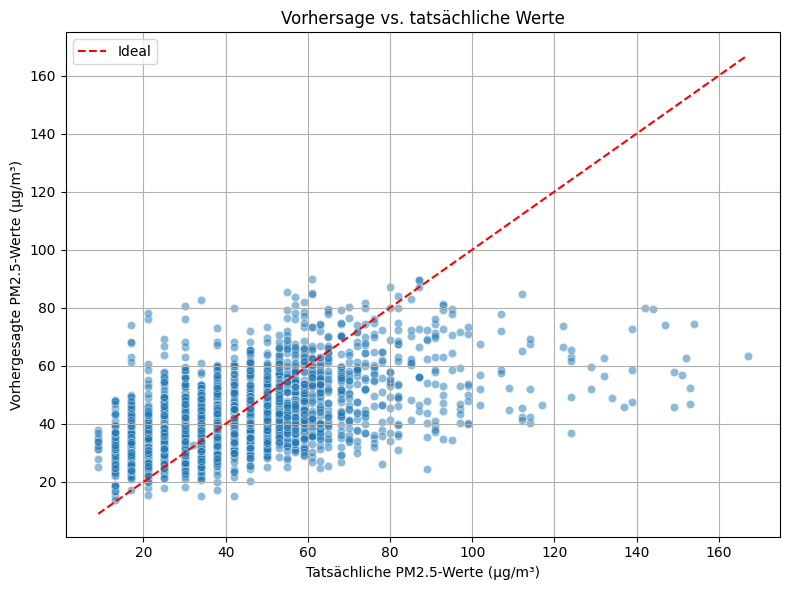

In [51]:
# Vorhersagen erzeugen
y_pred = model_quad_o3.predict(X_quad_o3)

# Scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_quad_o3, y=y_pred, alpha=0.5)
plt.plot([y_quad_o3.min(), y_quad_o3.max()],
         [y_quad_o3.min(), y_quad_o3.max()],
         color='red', linestyle='--', label='Ideal')
plt.xlabel('Tatsächliche PM2.5-Werte (µg/m³)')
plt.ylabel('Vorhergesagte PM2.5-Werte (µg/m³)')
plt.title('Vorhersage vs. tatsächliche Werte')
plt.legend()
plt.grid(True)
plt.tight_layout();


#### 📈 Vorhersage vs. tatsächliche Werte

Der Scatterplot zeigt die vom Modell vorhergesagten PM2.5-Werte im Vergleich zu den tatsächlich gemessenen Werten. Die rote Linie markiert den idealen Fall, in dem Vorhersage und Realität exakt übereinstimmen würden.

Beobachtungen:

- Im zentralen Bereich (ca. 20–80 µg/m³), wo die meisten Datenpunkte liegen, liegt ein Großteil der Punkte **unterhalb der Diagonalen** → das Modell **überschätzt die PM2.5-Werte** leicht.
- Ab etwa 80 µg/m³ Vorhersagewert steigt die Modellvorhersage weiter an – **obwohl die tatsächlichen Werte eine Obergrenze bei ca. 80 erreichen**.
- Daraus ergibt sich eine **systematische Überschätzung im oberen Wertebereich**, was darauf hindeutet, dass das Modell **keine natürliche Sättigung erkennt**.

Insgesamt liefert das Modell brauchbare Vorhersagen im Hauptbereich der Daten, tendiert jedoch dazu, **sehr hohe PM2.5-Werte zu überschätzen**, was bei linearen Modellen ohne Schranken ein bekanntes Phänomen ist.


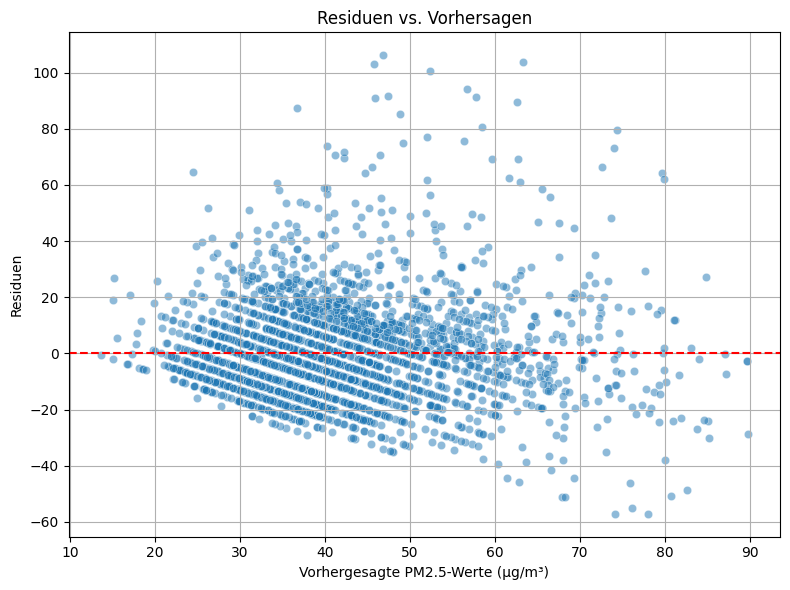

In [52]:
# Residuen berechnen
residuals = y_quad_o3 - y_pred

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Vorhergesagte PM2.5-Werte (µg/m³)')
plt.ylabel('Residuen')
plt.title('Residuen vs. Vorhersagen')
plt.grid(True)
plt.tight_layout();


#### 📉 Residuen vs. Vorhersagen

Der Residuenplot zeigt die Differenz zwischen tatsächlichem und vorhergesagtem PM2.5-Wert in Abhängigkeit vom Vorhersagewert. Idealerweise sollten sich die Punkte zufällig um die Null-Linie gruppieren – ohne erkennbares Muster.

- Die Punkte streuen relativ gleichmäßig um die Null-Linie → **kein systematischer Fehler** sichtbar.
- Kein klarer Trend in den Residuen → das Modell verzerrt die Vorhersagen nicht systematisch bei hohen oder niedrigen PM2.5-Werten.
- Die Varianz der Residuen scheint über den Wertebereich hinweg relativ konstant, das Kriterium der **Homoskedastizität** ist also weitgehend erfüllt.

➡️ Der Residuenplot unterstützt die Annahme, dass das Modell nicht nur gut angepasst ist, sondern auch robust und stabil im Fehlerverhalten.

#### 🔎 Auffälligkeit im Residuenplot: diagonale Streifen

Beim Residuenplot zeigen sich insbesondere im negativen Bereich der Residuen **schräg verlaufende Streifenmuster**. Diese diagonalen Anordnungen entstehen häufig, wenn:

- Eingabevariablen (z. B. Ozon oder NO₂) nur wenige diskrete Werte annehmen
- das Modell daraus kontinuierliche Vorhersagen erzeugt
- die tatsächlichen PM2.5-Werte wiederum gerundet vorliegen

➡️ Das Streifenmuster ist in diesem Fall kein Hinweis auf Modellfehler, sondern eher auf die **Granularität und Struktur der Eingangsdaten** zurückzuführen.




# 7. Modellvergleich

| Modell | Enthaltene Features | $R^2$ | Adj. $R^2$ | AIC | BIC | Bemerkung |
|--------|----------------------|----------|----------------|-----|-----|-----------|
| **1** | Wetter (linear) | 0.072 | 0.070 | ~25280 | ~25310 | Ausgangsmodell |
| **2** | Wetter (ohne Luftdruck) | 0.072 | 0.070 | ~25280 | ~25310 | `Pres` entfernt – kein Informationsverlust |
| **3** | + `log(Prcp + 1)` | 0.078 | 0.076 | ~25260 | ~25290 | Nichtlineare Transformation |
| **4** | + `Tavg²` | 0.122 | 0.120 | ~25120 | ~25160 | Quadratische Temperatur |
| **5** | + `Season` (Dummy) | 0.176 | 0.174 | ~24950 | ~25000 | Zeitstruktur eingebunden |
| **6** | + Schadstoffe (ohne `Pm10`, mit `Co`) | 0.283 | 0.280 | ~22870 | ~22940 | Stark verbesserte Modellgüte |
| **7** | Schadstoffe ohne `Co`, + `O3²` | **0.313** | **0.310** | ~24020* | ~24100* | Bestes Modell, plausibler Zusammenhang |

> \* Die AIC/BIC-Werte in Modell 7 sind durch mehr Beobachtungen nicht direkt vergleichbar mit Modell 6 (siehe Hinweis im Text).

➡️ Der Modellvergleich zeigt, wie systematisches Feature Engineering die Vorhersagegüte deutlich steigern kann:  

Durch die Kombination aus Transformationen, nichtlinearen Erweiterungen und der Einbindung zeitlicher sowie inhaltlich verwandter Einflussfaktoren konnte das Regressionsmodell von einem ursprünglichen $R^2§ von **0.072** auf **0.313** verbessert werden – eine Steigerung um über **330 %**.

